# Introduction to Deep Reinforcement Learning - Discounting
**Author: Logan Thomson**

[![GitHub](https://img.shields.io/badge/GitHub-Connect-181717?logo=github&logoColor=white)](https://github.com/xycoord)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Connect-blue)](https://www.linkedin.com/in/logan-thomson-01a4942ab)

[![GitHub](https://img.shields.io/badge/Star_Repository-gold?logo=github&logoColor=white)](https://github.com/xycoord/deep-rl-course)
[![GitHub Issues](https://img.shields.io/badge/Submit_Issue-red?logo=github)](https://github.com/xycoord/deep-rl-course/issues)

**Part 1:**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Lm_TI-Vrzai-WZQeZL3o7US07vVKWXlQ)


# Dependencies & Utils
These cells implement much of the code from the previous notebook which we will build upon. Run them first. *For this notebook, a CPU runtime is sufficient.*


In [ ]:
%%capture
!pip install swig
!pip install gymnasium[Box2D]

In [ ]:
from typing import Union, List, Callable
from abc import ABC, abstractmethod
from dataclasses import dataclass

import numpy as np
import torch
from torch import nn, optim, distributions

import gymnasium as gym

import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cpu")
dtype = torch.float32

Activation = Union[str, nn.Module]

_str_to_activation = {
    'relu': nn.ReLU(),
    'tanh': nn.Tanh(),
    'leaky_relu': nn.LeakyReLU(),
    'sigmoid': nn.Sigmoid(),
    'selu': nn.SELU(),
    'softplus': nn.Softplus(),
    'identity': nn.Identity(),
}

@dataclass
class MLPConfig:
    input_space: gym.Space
    output_space: gym.Space
    n_layers: int = 2
    size: int = 64
    activation: Activation = 'tanh'
    output_activation: Activation = 'identity'

    def __post_init__(self):
        if isinstance(self.activation, str):
            self.activation = _str_to_activation[self.activation]
        if isinstance(self.output_activation, str):
            self.output_activation = _str_to_activation[self.output_activation]

def size_from_space(space: gym.Space) -> int:
    if isinstance(space, gym.spaces.Box):
        return space.shape[0]
    elif isinstance(space, gym.spaces.Discrete):
        return space.n
    else:
        raise NotImplementedError

def build_mlp(config: MLPConfig) -> nn.Module:
    """
        Builds a feedforward neural network specified by config
    """

    in_size = size_from_space(config.input_space)
    out_size = size_from_space(config.output_space)

    layers = []

    for _ in range(config.n_layers):
        layers.append(nn.Linear(in_size, config.size))
        layers.append(config.activation)
        in_size = config.size
    layers.append(nn.Linear(in_size, out_size))
    layers.append(config.output_activation)

    mlp = nn.Sequential(*layers)
    mlp.to(device)
    return mlp


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)

def set_seed(seed):
    """Set all the seeds for reproducibility"""
    np.random.seed(seed)             # NumPy
    torch.manual_seed(seed)          # PyTorch on CPU
    torch.cuda.manual_seed(seed)     # PyTorch on GPU (single GPU)
    torch.cuda.manual_seed_all(seed) # PyTorch on all GPUs (multi-GPU)
    torch.backends.cudnn.deterministic = True  # Make CUDA deterministic
    torch.backends.cudnn.benchmark = False     # Disable CUDA benchmarking

In [ ]:
class Policy(ABC):

    @abstractmethod
    def get_action(self, observation: np.ndarray) -> np.ndarray:
        """ Select an action given the observation.
        Args:
            observation: an observation of the environment
        Returns:
            action: an action to take
        """

In [ ]:
class Agent(ABC):

    @property
    @abstractmethod
    def policy(self) -> Policy:
        """ The agent's policy """

    @abstractmethod
    def update(self, experiences):
        """ Update the agent's policy """
        raise NotImplementedError

In [ ]:
@dataclass
class ExperienceData:
    observations: torch.Tensor
    actions: torch.Tensor
    weights: torch.Tensor

In [ ]:
@dataclass
class Trajectory():
    observations: torch.Tensor
    actions: torch.Tensor
    rewards: torch.Tensor
    terminals: torch.Tensor
    truncateds: torch.Tensor
    total_reward: float
    length: int

In [ ]:
class TrajectoryBuilder():

    def __init__(self):
        self._observations = []
        self._actions = []
        self._rewards = []
        self._terminals = []
        self._truncateds = []
        self._done = False
        self._length = 0

    def add_experience(self, observation, action, reward, terminal, truncated):
        assert not self._done, "Trajectory is already done, call get_trajectory"

        self._done = terminal or truncated

        self._observations.append(observation)
        self._actions.append(action)
        self._rewards.append(reward)
        self._terminals.append(self._done)
        self._truncateds.append(truncated)

        self._length += 1

        return self._done

    @property
    def done(self) -> bool:
        return self._done

    @property
    def trajectory(self) -> Trajectory:
        assert self._done, "Trajectory is not complete, it must be either terminated or truncated"

        def list_to_tensor(x):
            return torch.tensor(np.array(x), dtype=dtype, device=device, requires_grad=False)

        # Convert lists to tensors
        observations = list_to_tensor(self._observations)
        actions = list_to_tensor(self._actions)
        rewards = list_to_tensor(self._rewards)
        terminals = list_to_tensor(self._terminals)
        truncateds = list_to_tensor(self._truncateds)

        total_reward = rewards.sum()

        return Trajectory(
            observations,
            actions,
            rewards,
            terminals,
            truncateds,
            total_reward,
            self._length
        )

In [ ]:
def sample_trajectory(env: gym.Env, agent: Agent) -> Trajectory:
    """Sample a trajectory in the environment from a policy."""

    # Reset the environment to start a new trajectory
    observation, info = env.reset()

    traj_builder = TrajectoryBuilder()

    # RL Loop
    while not traj_builder.done:

        # Select the action based on the observation
        action = agent.policy.get_action(observation)

        # Use that action to take a step in the environment
        new_observation, reward, terminated, truncated, info = env.step(action)

        # Record the experience
        # Note that we record the o_t not o_t+1
        traj_builder.add_experience(observation, action, reward, terminated, truncated)

        # Update the observation for the next loop
        observation = new_observation

    return traj_builder.trajectory

In [ ]:
def sample_trajectories(environment, agent, batch_size) -> List[Trajectory]:
    trajectories = []

    timesteps_so_far = 0
    while timesteps_so_far < batch_size:
        trajectory = sample_trajectory(environment, agent)
        trajectories.append(trajectory)
        timesteps_so_far += trajectory.length

    return trajectories

In [ ]:
def compile_trajectories(trajectories: list[Trajectory], calculate_weights: Callable[[torch.Tensor], torch.Tensor]) -> ExperienceData:

    # Use torch.cat to directly concatenate tensors from all trajectories
    observations = torch.cat([t.observations for t in trajectories], dim=0)
    actions = torch.cat([t.actions for t in trajectories], dim=0)

    # Calculate weights for each trajectory from its rewards
    weights = torch.cat([calculate_weights(t.rewards) for t in trajectories], dim=0)

    return ExperienceData(observations, actions, weights)

In [ ]:
class PGPolicy(Policy, nn.Module):
    def __init__(
        self,
        mlp_config: MLPConfig,
        learning_rate: float,
    ):
        # Call both parent initializers
        Policy.__init__(self)
        nn.Module.__init__(self)

        self.input_space = mlp_config.input_space
        self.output_space = mlp_config.output_space

        # Define the network
        if isinstance(self.output_space, gym.spaces.Discrete):
            self.logits_net = build_mlp(mlp_config)
            parameters = self.logits_net.parameters()
        elif isinstance(self.output_space, gym.spaces.Box):
            self.mean_net = build_mlp(mlp_config)
            # For continuous policies, logvar needs to match the action dimension (output_size)

            # We use log variances as parameters for numerical stability
            # This ensures variances remain positive when transformed via exp()
            # and prevents collapse to extremely small values during training
            output_size = self.output_space.shape[0]
            self.logvar = nn.Parameter(
                torch.zeros(output_size, dtype=dtype)
            )
            parameters = itertools.chain([self.logvar], self.mean_net.parameters())
        else:
            raise NotImplementedError


        # Initialise optimizer
        self.optimizer = optim.Adam(
            parameters,
            learning_rate,
        )

        # Move entire model to device
        self.to(device)


    def forward(self, observation: torch.FloatTensor) -> distributions.Distribution:
        """
        This function defines the forward pass of the network.
        """
        if isinstance(self.input_space, gym.spaces.Discrete):
            input = nn.functional.one_hot(observation.long(), num_classes=self.input_space.n).float()
        elif isinstance(self.input_space, gym.spaces.Box):
            input = observation
        else:
            raise NotImplementedError

        if isinstance(self.output_space, gym.spaces.Discrete):
            logits = self.logits_net(input)
            return distributions.Categorical(logits=logits)
        elif isinstance(self.output_space, gym.spaces.Box):
            mean = self.mean_net(input)
            covariance_matrix = torch.diag(torch.exp(self.logvar))
            return distributions.MultivariateNormal(mean, covariance_matrix)
        else:
            raise NotImplementedError

    @torch.no_grad()
    def get_action(self, observation: np.ndarray) -> np.ndarray:
        """Takes a single observation (as a numpy array) and returns a single action (as a numpy array)."""
        observation = torch.tensor(observation, dtype=dtype, device=device)
        distribution = self.forward(observation)
        action = distribution.sample()

        if isinstance(self.output_space, gym.spaces.Discrete):
            action = action.item()
        elif isinstance(self.output_space, gym.spaces.Box):
            action = action.to('cpu').detach().numpy()
        else:
            raise NotImplementedError

        return action


    def update(self, experiences: ExperienceData) -> float:

        self.optimizer.zero_grad()

        distribution = self.forward(experiences.observations)
        log_probs = distribution.log_prob(experiences.actions)
        surrogate_loss = -(log_probs * experiences.weights).mean()

        surrogate_loss.backward()
        self.optimizer.step()

        return surrogate_loss.item()


In [ ]:
class PGAgent(Agent):
    def __init__(self, policy_args):
        self._policy = PGPolicy(**policy_args)

    @property
    def policy(self) -> Policy:
        return self._policy

    def update(self, experiences: ExperienceData) -> float:
        return self._policy.update(experiences)

In [ ]:
class Tracker:
    def __init__(self):
        self.metrics = {}

    def log(self, metrics_dict, step=None):
        """Log metrics at a specific step"""
        for key, value in metrics_dict.items():
            if key not in self.metrics:
                self.metrics[key] = []
            self.metrics[key].append(value)

    def plot(self, metric_name, y_max=500):
        """Plot a single metric"""
        if metric_name in self.metrics:
            plt.figure(figsize=(8, 4))
            plt.plot(self.metrics[metric_name])
            plt.title(metric_name.capitalize())
            plt.xlabel('Step')
            plt.ylabel(metric_name)
            plt.ylim(top=y_max)
            plt.grid(True)
            plt.show()

    def plot_all(self, y_max=500):
        """Plot all metrics"""
        for metric_name in self.metrics:
            self.plot(metric_name, y_max=y_max)

# Discounting

The defining feature of reinforcement learning is its approach to learning long-term tasks one step at a time. Unlike simpler approaches, RL enables agents to care about future rewards, not just immediate ones. However, once we decide to care about the future, three important questions emerge:

1. How do we value rewards at different points in the future?
2. How can we mathematically handle rewards extending infinitely into the future?
3. How should we balance immediate vs. future rewards for optimal learning?

In this notebook, I'll discuss a technique called discounting which gives us a way to specify our answers to all three questions. While the mathematical implementation is nearly identical in all cases, recognizing these different purposes helps clarify how discounting is used.


# Discounting for Time Preference

When we decide how much to value rewards at different points in the future, we're making a fundamental statement about what objectives our agent should prioritize. In many scenarios, there are legitimate reasons to value near-term rewards more highly than distant ones:

* Inherent time preference - Like humans who prefer £100 today over £100 next year, an agent might inherently value immediate rewards more.
* Uncertainty in dynamic environments - Future states may become increasingly unpredictable, making future rewards less reliable.
* Opportunity costs - Early rewards could enable additional opportunities that might be missed by waiting.
* Risk of termination - In many real-world applications, the probability of the task ending prematurely increases with time.

These considerations lead us to the concept of discounting future rewards. Recall the RL objective:

$$J(\theta)=\mathbb E_{\tau\sim p_\theta(\tau)}[r(\tau)]$$

Where:

$\quad r(\tau) = \sum_{t=0}^T r_t$

We express the discounted objective as:

$$J_\gamma(\theta)=\mathbb E_{\tau\sim p_\theta(\tau)}[r_\gamma(\tau)]$$

Where:

$\begin{align}\quad r_\gamma(\tau) &= \sum_{t=0}^T \gamma^t r_t \\&=r_0 + \gamma r_1 + \gamma^2 r_2 + \cdots\end{align}$

$\quad \gamma$ is the **discount factor** (typically between 0.9 and 0.99)

The choice of $\gamma$ directly defines how much our agent values future rewards. With $\gamma = 0.9$, rewards 10 steps ahead retain only 35% of their value $(0.9^{10} \approx 0.35)$, while with $\gamma = 0.99$, they retain 90% $(0.99^{10} \approx 0.9)$. This effectively determines our agent's time horizon—how far into the future it should care about rewards.

A common rule of thumb is that the effective time horizon of a discounted objective is $1\over {1-\gamma}$.
- $\gamma = 0.9 \Rightarrow {1\over {1-\gamma}} = 10$
- $\gamma = 0.95 \Rightarrow {1\over {1-\gamma}} = 20$
- $\gamma = 0.99 \Rightarrow {1\over {1-\gamma}} = 100$

While the mathematical formulation captures all reasons for discounting, there's a particularly intuitive interpretation related to the risk of termination. This view treats $\gamma$ as the probability of surviving each timestep and $(1-\gamma)$ as the probability of termination. Maximizing discounted return then becomes mathematically equivalent to maximizing undiscounted return in an environment with random termination probability $(1-\gamma)$ per step.

Importantly, implementing the termination risk directly in the objective function with discounting produces lower variance estimates than actually sampling random terminations in the environment. Therefore, we often prefer this approach in practice.

Under this interpretation, the effective time horizon $1\over {1-\gamma}$ is the expected number of timesteps before random termination (only the termination modeled by the discounting).

A similar but alternative interpretation views discounting as an alternative to constant truncation. With constant truncation, an agent values all pre-truncation rewards equally and post-truncation rewards not at all. Instead, imagine truncating each trajectory at a random step, with continuation probability $\gamma$ and truncation probability $(1-\gamma)$ per timestep. Discounting provides a mathematically equivalent but lower-variance estimator of this stochastic truncation process. Under this interpretation, $1\over {1-\gamma}$​ is the expected number of timesteps before truncation—the expected number of timesteps the agent values.

# Implementation - Time Preference

To show the effect of discount on the learnt policy, we will use an environment called Frozen Lake.

![Frozen_Lake.gif](https://gymnasium.farama.org/_images/frozen_lake.gif)

In this environment, the agent can move around an 8x8 grid (the image shows a smaller version), beginning in the top left square. The aim is to reach the bottom right square where a present is located. Upon reaching the present, they receive a reward of 1 and the episode terminates. They must avoid fixed holes in the ice else they will fall through and be terminated.

**Observations:** current position as an integer (0-63)

**Actions:** up, down, left, right

**Rewards:**
- +1 upon reaching the present (episode terminates)
- 0 at all other timesteps

There is an option to make the ice slippery so the agent is not guaranteed to move in the direction they choose, however, we disable this for our experiments, making the environment deterministic.

In the undiscounted case $(\gamma = 1.0)$, all successful trajectories earn a total reward of 1 regardless of path length. The agent has no reason to prefer shorter paths, as long as it reaches the goal within the 100-step limit. When we apply discounting $(\gamma < 1.0)$, the reward value decreases with each step taken, so if the reward of 1 is received sooner, its discounted value will be greater:

- A reward of $1$ received after $20$ steps with $\gamma=0.99$ is worth $0.99^{20} \approx 0.82$
- A reward of $1$ received after $40$ steps with $\gamma=0.99$ is worth $0.99^{40} \approx 0.67$

This incentivises the agent to find shorter paths to maximize the discounted objective.  Frozen Lake's simple reward structure makes it ideal for visualizing how discount factors shape policy optimization.

In [ ]:
lake_env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False)

lake_mlp_config = MLPConfig(
    input_space=lake_env.observation_space,
    output_space=lake_env.action_space,
    n_layers=2,
    size=64,
    activation='tanh',
    output_activation='identity',
)

lake_policy_args = {
    "mlp_config": lake_mlp_config,
    "learning_rate": 2e-3,
}

Let's now implement the discounted sum $r_\gamma(\tau)= \sum_{t=0}^T \gamma^t r_t $

In [ ]:
def discounted_sum_of_rewards(rewards: torch.Tensor, gamma: float) -> float:
    # Create discount powers: [1, gamma, gamma^2, ...]
    indices = torch.arange(len(rewards), dtype=rewards.dtype, device=rewards.device)
    discount_powers = gamma ** indices

    # Apply discounting to rewards
    discounted_rewards = rewards * discount_powers

    # Sum discounted rewards
    total_discounted_reward = discounted_rewards.sum()

    return total_discounted_reward

We use this function in two ways:
1. As the objective metric - *cumulative reward*.
2. To calculate the weights for the surrogate loss.

For the second case, `compile_trajectories` requires a function that takes the rewards and returns a weight for each experience. Therefore, we create a lambda to bake in the `discount` and assign the discounted sum as the constant weight for all timesteps in the trajectory.

In addition to logging the average cumulative reward, we track two metrics that highlight how discount affects behavior:

* **Success rate:** the proportion of trajectories where the agent successfully reaches the present
* **Average length of successful trajectories:** the number of steps taken to reach the present in successful runs

With this in mind, we can write the training loop:

In [ ]:
def train_agent_discounted_objective(agent, environment, batch_size, num_updates, discount):

    # Use a lambda to make a calculate weights with the specified discount
    calculate_weights = lambda rewards: torch.ones_like(rewards) * discounted_sum_of_rewards(rewards, discount)

    tracker = Tracker()

    for step in tqdm(range(num_updates)):

        trajectories = sample_trajectories(environment, agent, batch_size)
        experience_data = compile_trajectories(trajectories, calculate_weights)
        loss = agent.update(experience_data)

        # Compute Metrics
        average_cumulative_reward = np.mean([discounted_sum_of_rewards(t.rewards, discount) for t in trajectories])
        successful_trajectories = [t for t in trajectories if t.total_reward > 0]
        success_rate = len(successful_trajectories) / len(trajectories)
        successful_trajectories_length = np.mean([t.length for t in successful_trajectories]) if successful_trajectories else 0

        # Log Metrics
        tracker.log({"Average Cumulative Reward": average_cumulative_reward})
        tracker.log({"Success Rate": success_rate})
        tracker.log({"Successful Trajectories Length": successful_trajectories_length})


    tracker.plot("Average Cumulative Reward", y_max=1)
    tracker.plot("Success Rate", y_max=1)
    tracker.plot("Successful Trajectories Length", y_max=100)

    environment.close()
    return agent

Let's run an experiment with discounts 1.0 (no discount), 0.99, 0.98. While these might seem like small changes, remember that discounting is an exponential decay.

Discount:  1.0


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


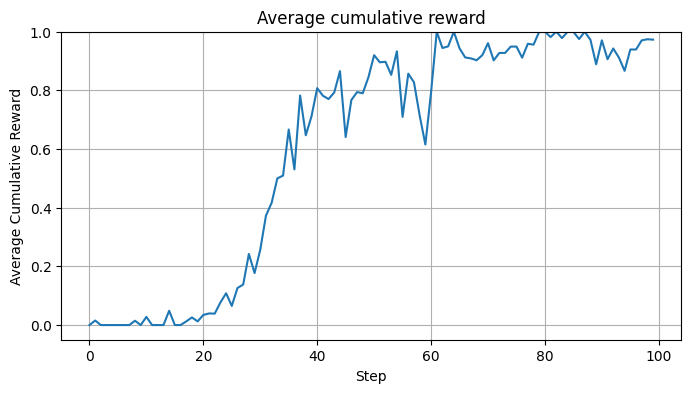

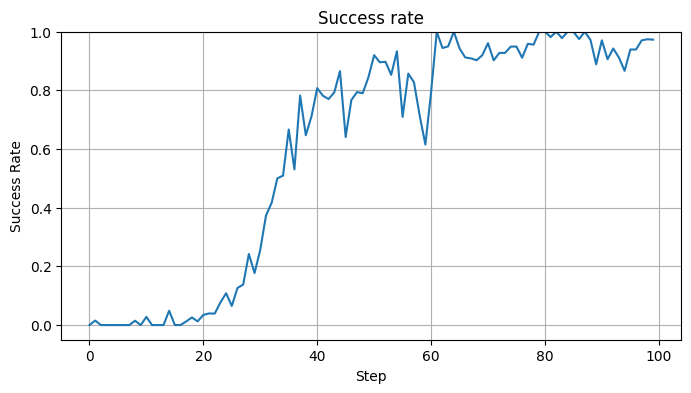

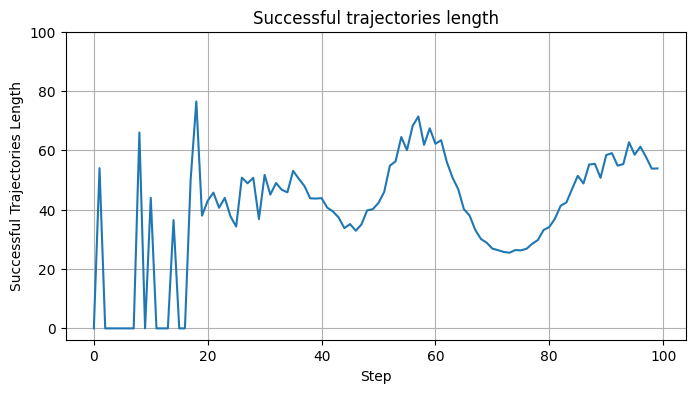

Discount:  0.99


100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


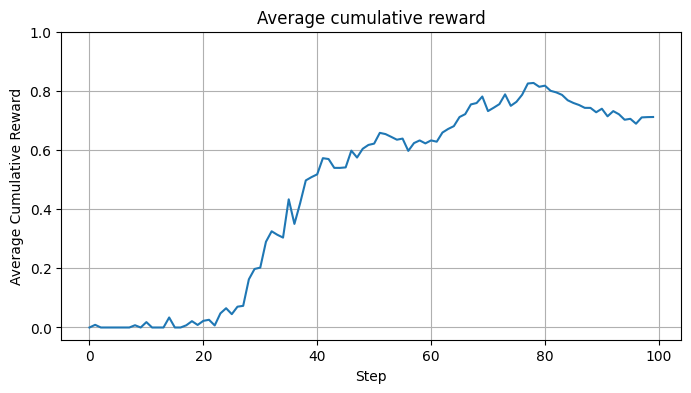

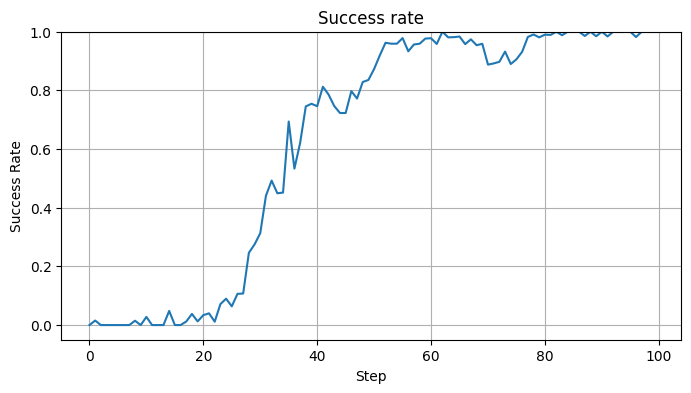

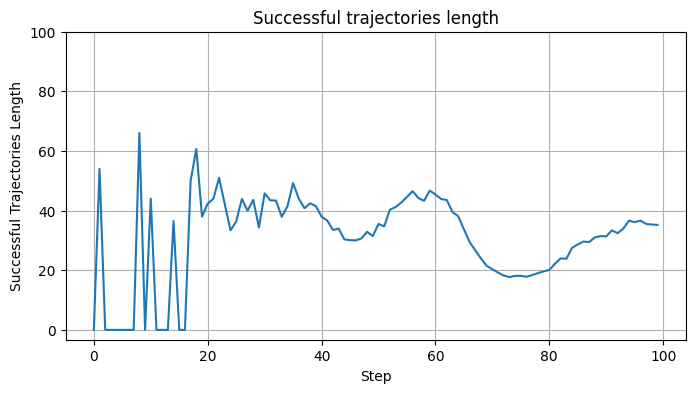

Discount:  0.98


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


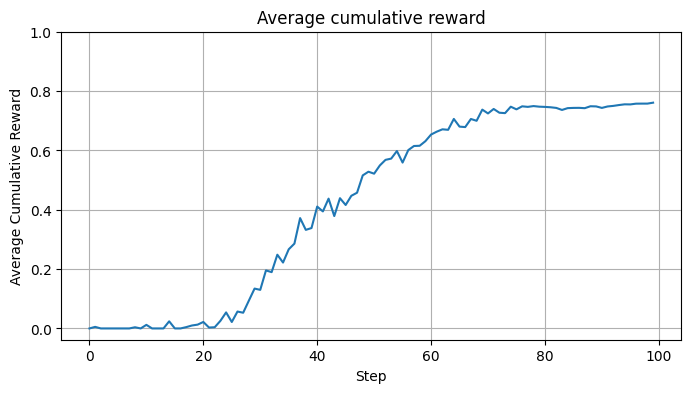

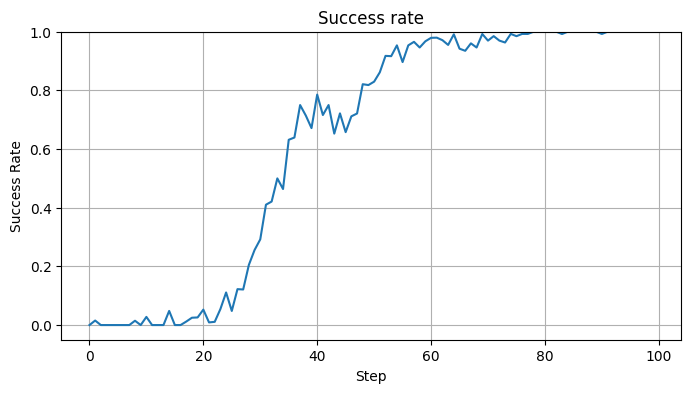

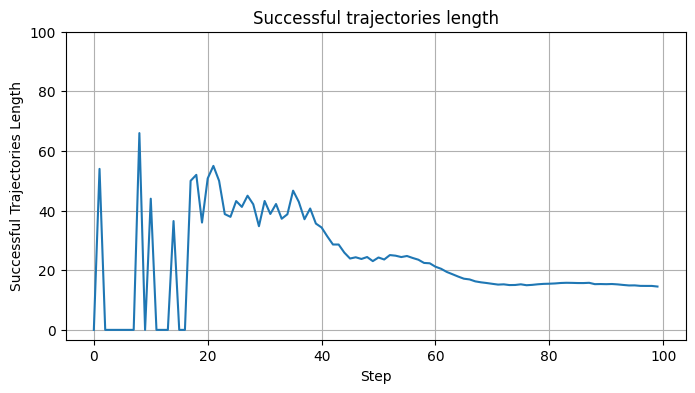

Discount:  0.8


100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


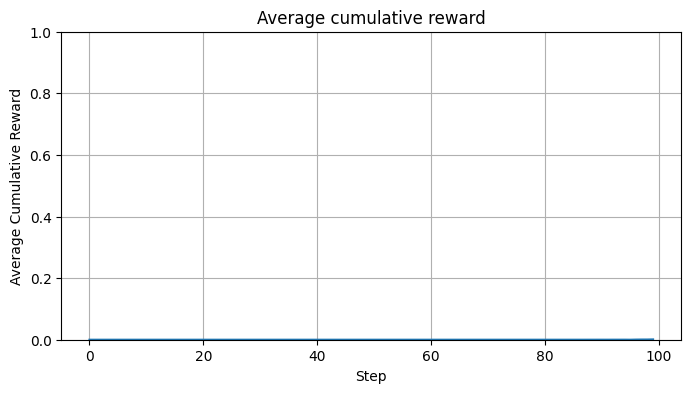

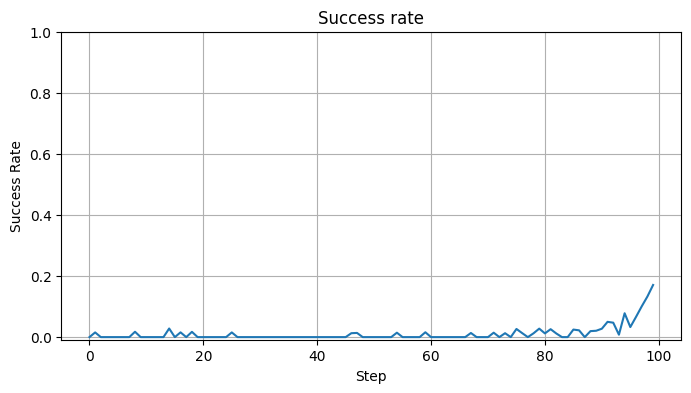

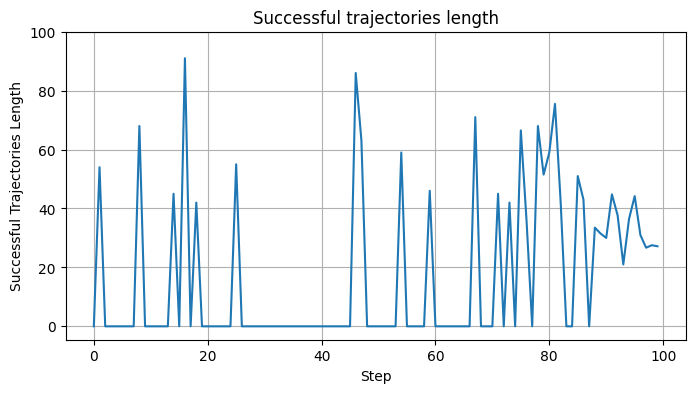

In [ ]:
discounts = [1.0,0.99,0.98,0.8]
seed = 1
for discount in discounts:
    print("Discount: ", discount)

    set_seed(seed)
    lake_env.reset(seed=seed)

    pgagent = PGAgent(lake_policy_args)
    train_agent_discounted_objective(pgagent, lake_env, batch_size=2000, num_updates=100, discount=discount)

Let's compare each of these metrics in turn.

First, examining the success rate curves, we observe that the higher discount factors $(1.0, 0.99, 0.98)$ achieve approximately 100% success by around step 60. However, when the discount factor is lower $(\gamma = 0.8)$, the agent fails to learn a reliable successful path. This is because, in this environment the shortest possible solution requires 15 steps, so any rewards it receives are discounted by at least $0.8^{15}=0.03$, meaning that the weights and consequently the gradients are very small.

Second, and most significantly, we observe a clear relationship between the discount factor and the length of successful trajectories. As the discount factor decreases from $\gamma=1.0$ to $\gamma=0.98$, the average path length dramatically shortens—from solutions between 40-60 steps to paths consistently shorter than 20 steps. This result directly confirms our theoretical hypothesis: discounted objectives inherently prefer shorter solutions. The magnitude of this effect is particularly striking. A seemingly small change in discount factor (just 0.02) produces a reduction in path length of more than 50%.

Finally, we observe an important nuance: even though the agent with discount factor $\gamma=0.98$ learns a more efficient policy (shorter trajectories with equal success rate), the agent with no discount $(\gamma=1.0)$ achieves a higher cumulative reward. This occurs because we're measuring the *discounted* cumulative reward: when the agent with $\gamma=0.98$ successfully reaches the goal in 15 steps (the shortest possible path), its terminal reward of 1 is discounted to $0.98^{15}\approx0.74$. This illustrates an important point: discounted cumulative rewards are not directly comparable across experiments using different discount factors, even when evaluating otherwise identical tasks.

These experiments were specifically selected to demonstrate the influence of discounting on path length optimization. In reality, the effect varies across environments and configurations. For instance, in the smaller 4x4 Frozen Lake map, agents naturally converge to short policies even without discounting, as there are fewer possible routes to the present. Similarly, when enabling the 'slippery' option (which introduces stochasticity), agents naturally develop a preference for shorter routes to minimize the cumulative risk of falling through holes. These variations highlight how the theoretical principles of discounting interact with specific environment characteristics.

# Discounting for Convergence

For non-episodic environments (that don't terminate), the number of timesteps is infinite. In such environments, we typically wish for the policy to perform well for an arbitrarily long time. For instance, a financial agent trading stocks or a robot learning to walk. However this creates a fundamental mathematical challenge. Without discounting, the expected sum of rewards may diverge, making the optimization objective undefined.

To illustrate this problem, consider a simple case where an agent receives a constant positive reward $r$ each timestep in a non-terminating environment:

$$\sum_{t=0}^{\infty} r_t = r + r + r + \cdots = \infty \quad \text{(if } r > 0 \text{)}$$

In most practical scenarios, summing the rewards over infinite timesteps will fail to converge, making it impossible to meaningfully compare or optimize policies.

Discounting elegantly solves this mathematical problem. For any bounded reward function where $|r_t| \leq R_{max}$ for all $t$, the discounted sum converges to a finite value:

$$\left|\sum_{t=0}^{\infty} \gamma^t r_t\right| \leq \sum_{t=0}^{\infty} \gamma^t R_{max} = \frac{R_{max}}{1-\gamma}$$

This convergence property has important algorithmic implications:
- It creates a well-defined objective function that can be differentiated
- It ensures that gradient estimates remain bounded
- It allows meaningful comparison between different policies

Previously, we discussed *truncation* as another approach for handling non-converging infinite horizons. Both techniques involve an arbitrary choice that modifies the true objective—selecting a truncation timestep or a discount factor $\gamma$. The key difference is that truncation creates a hard boundary where future rewards abruptly become worthless, while discounting provides a smooth decay of reward values. Discounting offers mathematical advantages for theoretical analysis, including guaranteed convergence and cleaner properties for optimization. In practice, we often use both approaches together: discounting for its theoretical soundness and smooth credit assignment, and truncation for implementation feasibility.

## Selecting $\gamma$

To ensure convergence of the objective, the only constraint on $\gamma$ is that $\gamma < 1$. Beyond this, the specific choice of $\gamma$ should reflect our design preferences from the previous section - how do we value rewards at different points in the future?

## Example: Inverted Pendulum

A simple example of an infinite time horizon environment is the inverted pendulum control problem. In this environment, the pendulum begins at a random angle and angular velocity, and the agent applies torque to balance it upright. The reward function penalizes deviation from the upright position, angular velocity, and control effort (torque).

The environment uses a 200-step limit by default. Without this, any non-perfect policy would have rewards summing to $-\infty$. The [docs](https://gymnasium.farama.org/environments/classic_control/pendulum/) tell us that the reward is bounded by $[-16.2736044,0]$. Therefore, we can use discounting to ensure the sum-of-rewards converges.

Without discounting:
$$\sum_{t=0}^{\infty}r_t \ge \sum_{t=0}^{\infty} -16.2736044 = -\infty$$

With discount $\gamma = 0.99$:
$$\sum_{t=0}^{\infty}\gamma^tr_t \ge \sum_{t=0}^{\infty} \gamma^t (-16.2736044) = \frac{-16.2736044}{1-0.99} \approx -1627.36$$

![Inverted_Pendulum.gif](https://gymnasium.farama.org/_images/pendulum.gif)

# Discounting for Variance Reduction

Discounting the training objective acts as a variance reduction technique.
Future rewards typically have higher uncertainty than immediate ones because stochasticity in both the policy and the environment compounds over time. At each timestep, the action leads to a distribution of possible next states. From these states, further actions create even more possibilities, forming an exponentially growing tree of potential trajectories. This means distant rewards come from a much wider distribution of possible scenarios than immediate ones, which typically translates to a much higher variance in the distant rewards themselves. These high-variance distant rewards contribute disproportionately to the overall variance in policy gradient estimates. By applying discounting, we systematically reduce their influence, thereby lowering the overall variance of our policy gradient estimates.

When using discounting for variance reduction, it's crucial to distinguish between two different objectives:

> The **True Objective** (or Evaluation Objective) represents our genuine preference over reward timing. This is what we use to evaluate the final performance of our agent.

> The **Training Objective** is what we optimize during training. It can differ from the true objective for computational or statistical reasons which help to improve the performance we can practically achieve.

Unlike reward-to-go, which is an unbiased variance reduction technique, discounting introduces bias into the learning process. When we apply additional discounting to the training objective purely for variance reduction, we bias it to prefer shorter-term rewards, even if this doesn't match our true preferences.

This creates a classic bias-variance trade-off: the greater the discount, the more we reduce variance but at the cost of increasing the mismatch between what we're optimizing and what we actually care about. Finding the optimal balance requires empirical tuning for each specific environment and algorithm.

To illustrate this trade-off, consider training a robot to run. Suppose the true objective is to maximise how far it can travel in 1000 timesteps. With no discounting ($\gamma = 1.0$), the training objective would match our true objective perfectly, but learning might be extremely difficult due to the high variance from distant, uncertain rewards. On the other hand, if we discount the training objective too much (e.g. $\gamma=0.8$), the agent might find a local optimum where it simply falls over in the first 5 timesteps and receive high immediate reward. The optimal training discount lies somewhere in the middle.

Before we implement discounting for variance reduction and show how it affects policy performance in practice, let's consider how discounting interacts with reward-to-go - the first tool for variance reduction introduced in Part 1.

# Combining Reasons

The three reasons for discounting, while distinct, are not mutually exclusive. We've already covered how discounting for convergence and discounting for
time preference interact.

When we want to discount both for time preference and variance reduction, we can use two discount factors:
- $\gamma_1$ for the true objective (time preference)
- $\gamma_2$ for additional training discount (variance reduction)

There are two ways to combine these discounts:

1. **Sequential application**: First discount the true objective with $\gamma_1$, then apply $\gamma_2$ to this already discounted objective to get the training objective. This means, in the training objective, the effective discount of $r_t$ becomes $(\gamma_1\cdot\gamma_2)^t$.

2. **Independent application**: We maintain $\gamma_1$ as the discount factor for evaluation, but use $\gamma_2$ exclusively for training. In this case, $\gamma_2\le\gamma_1$, else the training objective would both be biased and have higher variance than the true objective.

*Note: The terms "Sequential application" and "Independent application" aren't standard technical terms.*

These two approaches are mathematically equivalent when using basic policy gradients without reward-to-go - they simply represent different conceptual frameworks for thinking about discount factors. The first separates the discounts by reason, while the second separates the evaluation objective from the training objective. This distinction becomes more meaningful when combined with reward-to-go, which we'll explore next.

# Discounting and Reward-to-go
When combining discounting with reward-to-go, we must carefully consider how these techniques interact. Since reward-to-go is used for calculating policy gradient weights (per action) rather than evaluating overall trajectory performance, our focus here is on the training objective weights.

Let's first consider the case where our true objective is the discounted sum-of-rewards, $J_\gamma(\theta) = \mathbb{E}[\sum_{t=0}^T \gamma^t r_t]$. If we directly apply the reward-to-go derivation from the previous notebook to this objective, the resulting weight for the action at timestep $t$ is:

$$w_t^{\text{Direct}} = \sum_{k=t}^T \gamma^k r_k = \gamma^t r_t + \gamma^{t+1} r_{t+1} + \gamma^{t+2} r_{t+2} + \dots$$

This formulation mathematically corresponds precisely to the gradient of the discounted objective $J_\gamma$.  However, it presents a practical challenge: the explicit $\gamma^t$ factor scales down the entire gradient contribution for actions taken later in the episode relative to earlier ones. This can make learning less stable and disproportionately dependent on experiences from early in trajectories.

To address this issue and promote more stable learning across the entire trajectory, a different formulation for the weight is commonly used in practice. This involves calculating the discounted sum of rewards relative to the current timestep t:

$$w_t^{\text{Relative}} = \sum_{k=t}^T \gamma^{k-t} r_k = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + \dots$$

This formulation, often denoted $G_t$​, calculates the return achieved from state $s_t$​ onwards, discounted back to time t. Crucially, it maintains the ratio of the rewards that contribute to each weight. This preservation of the relative temporal discounting structure means $w_t^{\text{Relative}} $ accurately represents the value of future rewards from the perspective of time $t$, justifying its use as the weight for optimizing $J_\gamma$.

The mathematical relationship between the two weights is:

$$ w_t^{\text{Direct}} = \gamma^t \cdot w_t^{\text{Relative}} $$

Therefore, using $w_t^{\text{Relative}}$  as the weight is equivalent to removing the scalar factor $\gamma^t$.

Importantly, this rescaling does change the relative magnitude of updates from different timesteps. By removing the $\gamma^t$ factor, we prevent the influence of later timesteps being exponentially suppressed. This leads to a more balanced contribution from all steps in the trajectory to the overall gradient estimate, often resulting in significantly more stable and faster learning in practice. Using $w_t^{\text{Relative}}$ doesn't yield the exact gradient of $J_\gamma$. However, this practical modification effectively improves the policy.

The **Relative** formulation is also the natural choice when using discounting for variance reduction. Because of its practical advantages and applicability across the different reasons for discounting, it is the standard way discounted reward-to-go weights are calculated.

Combining Motivations: If you need to discount for both time preference and apply additional discounting for variance reduction during training you can use two discounts in either way described in the previous section.

# Implementation: Variance Reduction

Now that we understand the theory behind discounted reward-to-go, let's implement it and test how different discount factors affect learning performance. In our example, we will use the Relative formulation as is standard. We start by implementing the weights calculation function for this case.

In [ ]:
def discounted_reward_to_go(rewards: torch.Tensor, gamma: float) -> torch.Tensor:
    """
    Computes discounted reward-to-go using a reverse loop
    and negative indexing for the last element.
    w_t = r_t + gamma * w_{t+1}
    """
    num_steps = len(rewards)

    # Create empty tensor to populate with the weights
    rtg = torch.zeros_like(rewards)

    # The last step, T, is the base case: w_T = r_T
    if num_steps > 0:
        rtg[-1] = rewards[-1] # Use -1 for the last element

    # Iterate backward
    #   from the second-to-last step (index num_steps - 2)
    #   down to the first step (index 0).
    for t in range(num_steps - 2, -1, -1):
        # Apply the recursive formula:
        rtg[t] = rewards[t] + gamma * rtg[t+1]

    return rtg

When implementing the training loop, we use this `discounted_reward_to_go` function for calculating the weights but a simple undiscounted sum of rewards for evaluation.

In [ ]:
def train_agent_discounted_rtg(agent, environment, batch_size, num_updates, discount):
    # Use a lambda to make a calculate weights with the specified discount
    calculate_weights = lambda rewards: discounted_reward_to_go(rewards, discount)

    tracker = Tracker()

    for step in tqdm(range(num_updates)):

        trajectories = sample_trajectories(environment, agent, batch_size)
        experience_data = compile_trajectories(trajectories, calculate_weights)
        loss = agent.update(experience_data)

        # Average undiscounted sum of rewards
        average_cumulative_reward = np.mean([t.total_reward for t in trajectories])
        tracker.log({"Average Cumulative Reward": average_cumulative_reward})

    tracker.plot("Average Cumulative Reward", y_max=200)

    environment.close()
    return agent

For this demonstration, we'll use a new environment Lunar Lander which demonstrates the bias-variance trade-off well. In this environment, the aim is to land a rocket without crashing, doing so quickly and without using too much fuel.

![Lunar Lander](https://gymnasium.farama.org/_images/lunar_lander.gif)

Full specifications can be read in [the docs](https://gymnasium.farama.org/environments/box2d/lunar_lander/).

In [ ]:
lunar_env = gym.make('LunarLander-v3')

lunar_mlp_config = MLPConfig(
    input_space=lunar_env.observation_space,
    output_space=lunar_env.action_space,
    n_layers=2,
    size=64,
    activation='tanh',
    output_activation='identity',
)

lunar_policy_args = {
    "mlp_config": lunar_mlp_config,
    "learning_rate": 1e-3,
}

We perform four runs across a range of discounts, each with the same seed to see how discounting for variance reduction affects performance with respect to the undiscounted true objective.

Discount:  1.0


100%|██████████| 300/300 [03:08<00:00,  1.60it/s]


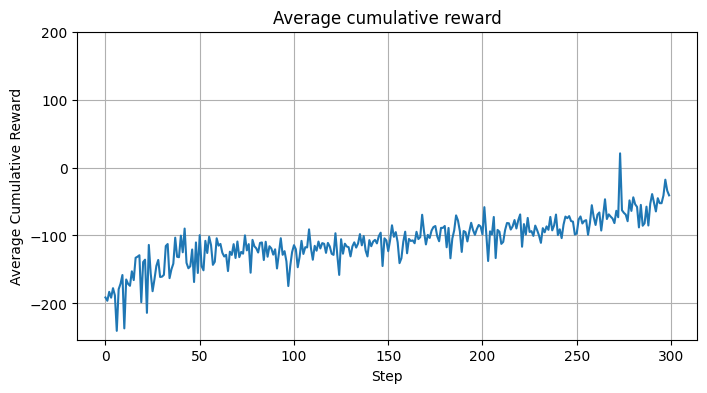

Discount:  0.99


100%|██████████| 300/300 [03:23<00:00,  1.47it/s]


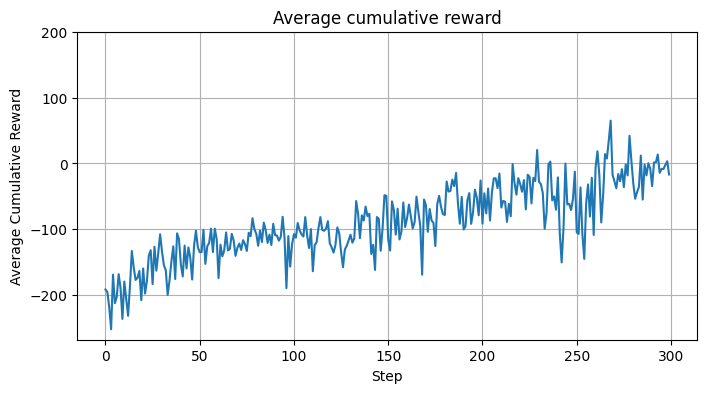

Discount:  0.98


100%|██████████| 300/300 [03:21<00:00,  1.49it/s]


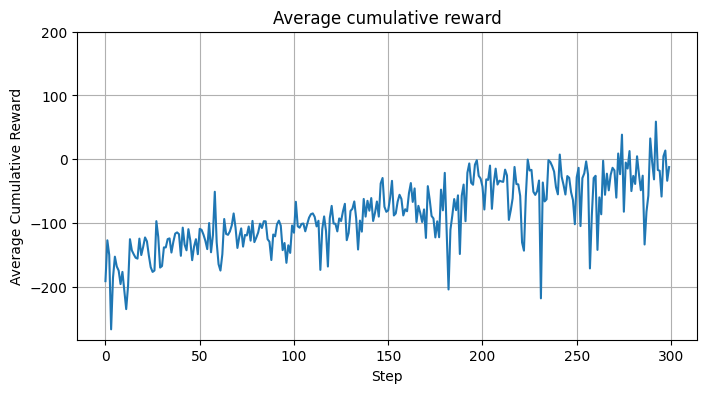

Discount:  0.97


100%|██████████| 300/300 [03:33<00:00,  1.41it/s]


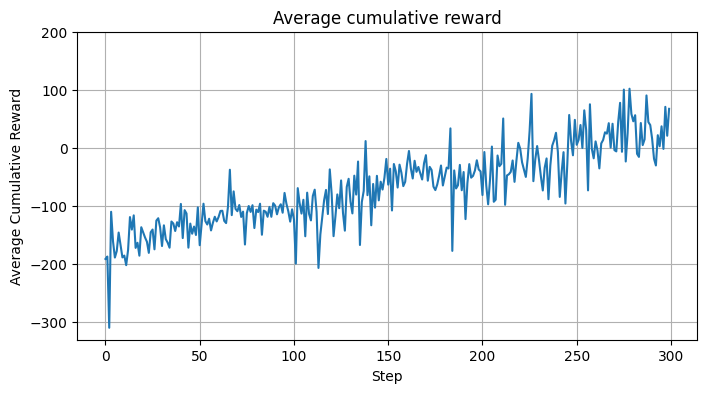

Discount:  0.95


100%|██████████| 300/300 [03:29<00:00,  1.44it/s]


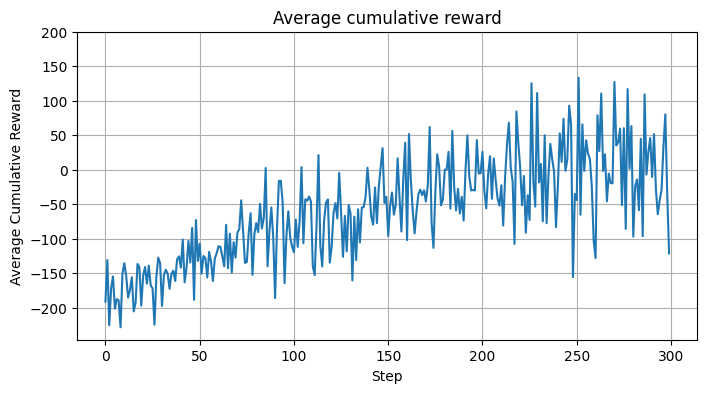

Discount:  0.9


100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


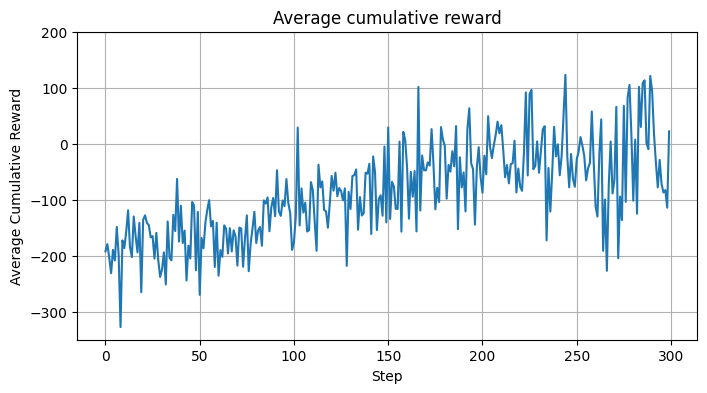

Discount:  0.85


100%|██████████| 300/300 [03:29<00:00,  1.43it/s]


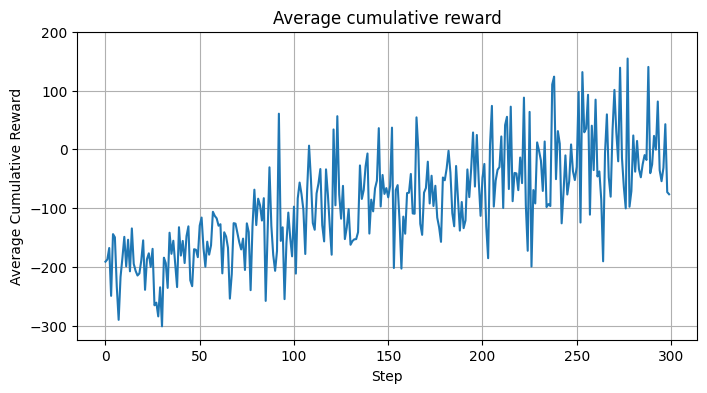

Discount:  0.8


100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


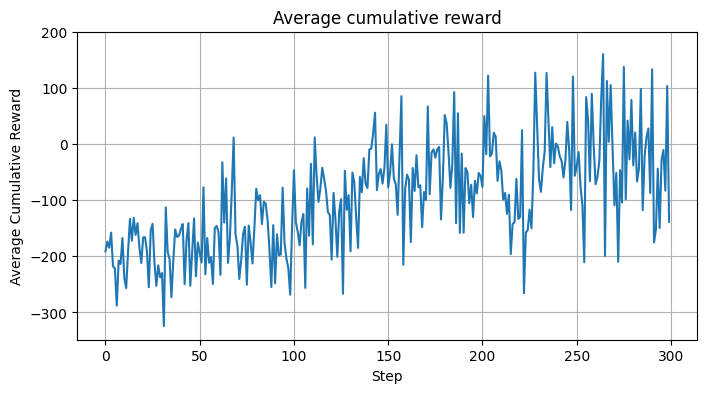

In [ ]:
discounts = [1.0, 0.99, 0.97, 0.95]
seed = 42
for discount in discounts:
    print("Discount: ", discount)

    set_seed(seed)
    lunar_env.reset(seed=seed)

    pgagent = PGAgent(lunar_policy_args)
    train_agent_discounted_rtg(pgagent, lunar_env, batch_size=1000, num_updates=300, discount=discount)

These experiments clearly demonstrate the bias-variance trade-off. As we decrease the discount factor from $\gamma=1.0$ to $\gamma=0.97$, we observe two significant effects: faster training convergence and improved final performance. This improvement stems from reduced variance in our gradient estimates as predicted by the theory.

However, further reducing $\gamma$ to $0.95$ reveals the downside. While initial learning is even faster due to reduced gradient variance, the final policy shows much higher performance variability across episodes, with higher peaks but much lower troughs. One explanation for this is that the agent is failing to learn a good policy for the early timesteps. In Lunar Lander, the dominant reward is for landing the rocket which occurs only at late timesteps. When we use a low discount factor, this reward contributes little to the gradients corresponding to actions at early timesteps. Therefore, these gradients are small and the agent learns early timestep strategies much more slowly. Consequently, its performance becomes highly inconsistent, largely dependent on randomly getting into a good state early on. This demonstrates how overdiscounting can bias the learning objective detrimentally, trading reduced gradient variance for increased performance inconsistency.

This particular bias pattern emerges from the interaction between Lunar Lander's reward function and the discounting formulation. More broadly, different setups respond differently to discounting, with various bias patterns emerging as the discount factor decreases. For instance, when rewards are more evenly distributed over time, excessive discounting typically biases the model towards short-term rewards.

Sometimes, no discounting $(\gamma=1.0)$ is actually optimal. This can occur when discounting provides negligible variance reduction benefits. In environments with single terminal rewards (like winning/losing in chess), where reward variance is unrelated to timestep, discounting only introduces bias without reducing gradient variance.

The optimal discount factor also varies with training duration. In our Lunar Lander experiments, $\gamma=0.95$ performs best at 100 training steps despite its inconsistency later on. This highlights how the ideal discount depends not just on the environment but also on available training resources.

These observations suggest a practical approach: begin with higher discount factors and gradually decrease until learning stabilizes, while terminating poor-performing configurations early.

# Next Steps

Well done for getting through this part on discounting! It's far more in-depth than most introductory courses delve into this topic, but hopefully this more nuanced understanding will serve you well when making decisions in practice.
In the next part, we'll explore yet more advanced variance reduction methods which we'll use to improve the policy gradients algorithm:
- Baselines
- Actor Critic algorithms
- Generalised Advantage Estimation (GAE)

These techniques form the backbone of modern deep RL algorithms and enable us to tackle increasingly complex environments.

**Part 3: Baselines, Actor-Critic & GAE**

[![Read Blog Post](https://img.shields.io/badge/Read%20Blog%20Post-blue?style=flat)](https://loganthomson.com/Baselines-Actor-Critic-GAE/)

# Feedback and Contact Information

If you found this notebook useful, please consider:
- Sharing it with friends and colleagues who might benefit
- Starring the repository on GitHub
- Connecting with me on LinkedIn

[![GitHub](https://img.shields.io/badge/Star_Repository-gold?logo=github&logoColor=white)](https://github.com/xycoord/deep-rl-course)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Connect-blue)](https://linkedin.com/in/logan-thomson-01a4942ab)

If you found anything confusing, I'd be happy to answer any questions:

[![GitHub Issues](https://img.shields.io/badge/Submit_Issue-red?logo=github)](https://github.com/xycoord/deep-rl-course/issues)
[![GitHub Discussions](https://img.shields.io/badge/Join_Discussion-green?logo=github)](https://github.com/xycoord/deep-rl-course/discussions)

I'm continuously working to improve this material and extend it with additional topics. Your feedback helps make this resource better for everyone!